# TODO: experiments for...
1. All Solodoch latitudes
2. Zonal averages vs. full inputs
3. Detrend & deseason vs. not
4. Value of including time lags for covariates & MOC

In essence, this will serve as the basis for the argument for moving towards more heavyweight machine learning models--we want to show that linear regression works moderately well, but we can imporve the predictive performance further by moving into the realm of deep learning.

# Setup

In [1]:
import sys
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [3]:
# A helper function to turn numeric latitudes to into strings
def format_lat(lat):
    return str(-1 * lat) + 'S' if lat < 0 else str(lat) + 'N'

In [19]:
# A helper function to subset 30S, since now the surface vars exist for all longitudes
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

# Experiment variables

In [42]:
# CONSTANTS
data_home = '/Users/emiliolr/Google Drive/My Drive/GTC'
lats = [26, -30, -55, -60]

# CHANGE BASED ON EXPERIMENT
filename = f'full_static_zonal_avgs_detrend_deseason'
base_path = f'/Users/emiliolr/Desktop/regression_results'
remove_season = True
remove_trend = True

# MISCELLANEOUS
verbose = False

# Running linear regression experiments

In [43]:
# Looping through each latitude, prepping data, hyperparam tuning, and saving the results
for lat in lats:
    lat_str = format_lat(lat)
    filename_lat = f'{lat_str}_{filename}'
    print(f'Training on {lat_str}...')
    
    # Load in predictor vars
    inputs = xr.open_dataset(f'{data_home}/ecco_data_minimal/{lat_str}.nc')

    #  fixing longitude bounds of 30S
    if lat == -30:
        inputs = mask_30S(inputs)
    
    inputs = inputs.isel(latitude = 1) # pull out just the lat of interest
    inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better

    #  fixinng interior null values for 55S
    if lat == -55:
        inputs = inputs.dropna('longitude', how = 'all')

    # Load in response var
    outputs_fp = f'{data_home}/ecco_data_minimal/{lat_str}_moc_density.pickle'

    with open(outputs_fp, 'rb') as f:
        outputs = pickle.load(f)
    
    outputs = np.expand_dims(outputs, 1) # grabbing just 60S
    outputs = xr.Dataset(data_vars = {'moc' : (['time', 'latitude'], outputs)}, 
                         coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(lat)})

    # Preprocessing all inputs
    pp_data = apply_preprocessing(inputs,
                                  mode = 'inputs',
                                  remove_season = remove_season,
                                  remove_trend = remove_trend,
                                  standardize = True,
                                  lowpass = False)

    #  reshape inputs as desired and convert to a numpy array
    data_vars = ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
    pp_data_np = reshape_inputs(pp_data, keep_coords = ['time'], data_vars = data_vars)
    
    #  MOC strength from data
    strength = apply_preprocessing(outputs,
                                   mode = 'outputs',
                                   remove_season = remove_season,
                                   remove_trend = remove_trend,
                                   standardize = False,
                                   lowpass = False)
    strength_np = strength.moc.squeeze().values
    
    X = pp_data_np
    y = strength_np

    #  adding a intercept - ones in the first column
    X = sm.add_constant(X)

    #  train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False, 
                                                        stratify = None, random_state = 123456)
    
    # Define the hyperparameters to optimize over
    param_grid = {
        'alpha' : np.logspace(-4, 4, 10),
        'L1_wt' : np.linspace(0, 1, 10)
    }
    
    # TRAINING: grid search - 10-fold cross-validation
    grid_search = GridSearchCV(SMWrapper(), param_grid, cv = 10, scoring = 'neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    #  report best result
    if verbose:
        print(f'Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}')
    
    #  calculate test performance and optionally report
    y_pred = grid_search.best_estimator_.predict(X_test)
    metric_dict = {}
    
    metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
    metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
    metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
    metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)

    if verbose:
        print(metric_dict)

    # Saving regression results to a text file for re-interpretation later
    txt_fp = f'{base_path}/{filename_lat}_RESULTS.txt'
    reg_results_txt(grid_search, txt_fp, data_vars, metric_dict)

    # Extracting all predictions in time order
    train_set_pred = grid_search.best_estimator_.predict(X_train)
    test_set_pred = grid_search.best_estimator_.predict(X_test)
    all_preds = np.concatenate([train_set_pred, test_set_pred])

    # Plotting results: timeseries
    time = outputs.time.values
    fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
    
    plt_fp = f'{base_path}/{filename_lat}_TIMESERIES.png'
    plt.savefig(plt_fp, bbox_inches = 'tight')
    plt.close()

    # Plotting results: scatterplot
    fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
    
    plt_fp = f'{base_path}/{filename_lat}_SCATTER.png'
    plt.savefig(plt_fp, bbox_inches = 'tight')
    plt.close()

    print('------')

Training on 26N...
axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)
------
Training on 30S...
axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)
------
Training on 55S...
axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)
------
Training on 60S...
axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)
------


# Source code for experiment loop

In [35]:
lat = '55S'
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat}.nc")

# inputs = mask_30S(inputs)

inputs = inputs.isel(latitude = 1) # pull out just 60S
inputs = inputs.expand_dims({'latitude' : 1}) # add back in latitude dim to make things work better
inputs

<xarray.Dataset>
Dimensions:    (latitude: 1, time: 312, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -54.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (latitude, time, longitude) float32 -0.3674 -0.3674 ... -0.2765
    ZWS        (latitude, time, longitude) float32 0.09067 0.09067 ... 0.1572
    OBP        (latitude, time, longitude) float32 56.01 56.01 ... 54.15 54.15
    SSS        (latitude, time, longitude) float32 34.17 34.17 ... 34.2 34.2
    SST        (latitude, time, longitude) float32 9.228 9.228 ... 8.168 8.168

In [37]:
inputs.dropna('longitude', how = 'all').isnull().sum()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    SSH      int64 0
    ZWS      int64 0
    OBP      int64 0
    SSS      int64 0
    SST      int64 0

In [27]:
outputs_fp = f"{data_home}/ecco_data_minimal/{lat}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f)

outputs = np.expand_dims(outputs, 1) # grabbing just 60S
outputs = xr.Dataset(data_vars = {'moc' : (['time', 'latitude'], outputs)}, 
                     coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(-30)})
outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int64 -30
Data variables:
    moc       (time, latitude) float64 -22.84 -21.31 -22.59 ... -20.17 -23.13

In [8]:
# Apply whatever preprocessing we want *before* calling reshape_inputs
remove_season = True
remove_trend = True

pp_data = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=remove_season,
                              remove_trend=remove_trend,
                              standardize=True,
                              lowpass=False)

# Reshape as desired and convert to a numpy array
data_vars = ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
pp_data_np = reshape_inputs(pp_data, keep_coords=["time"], data_vars = data_vars)

# MOC strength from data
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=remove_season,
                               remove_trend=remove_trend,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values

X = pp_data_np
y = strength_np

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)

axes: ['time', 'feature']
variables: ['SSH', 'SST', 'SSS', 'OBP', 'ZWS']
shape: (312, 5)

Inputs shape: (312, 5)
Outputs shape: (312,)


In [9]:
# Add bias term to dataset (ones in the first column)
X = sm.add_constant(X)

# Train/val/test split - no shuffling to ensure that the first 70% of timeseries is train and the last 30% is test!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

# Hyperparameters to optimize over
param_grid = {
    "alpha": np.logspace(-4, 4, 10),
    "L1_wt": np.linspace(0, 1, 10)
}

# Grid search - 10-fold cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Report best result
print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

# Report test performance
y_pred = grid_search.best_estimator_.predict(X_test)
r2 = round(r2_score(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
rmse = round(root_mean_squared_error(y_test, y_pred), 3)
mae = round(mean_absolute_error(y_test, y_pred), 3)

print(f"Test R^2: {r2}")
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

Best MSE (cross-validation): 10.602
Test R^2: 0.766
Test MSE: 9.124
Test RMSE: 3.021
Test MAE: 2.224


In [10]:
test_metrics = {'RMSE' : rmse, 'MAE' : mae}

In [11]:
# Saving regression results to a text file for re-interpretation later
txt_fp = f'/Users/emiliolr/Desktop/{filename}.txt'
reg_results_txt(grid_search, txt_fp, data_vars, test_metrics)

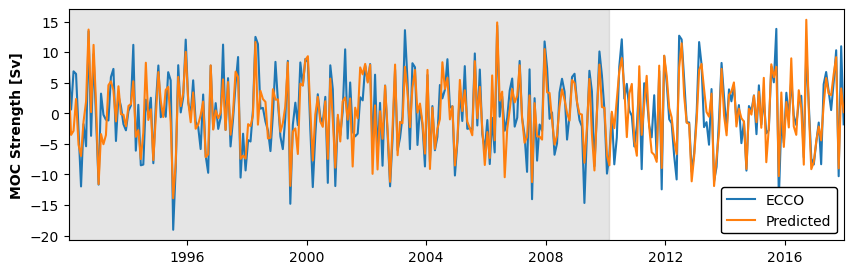

In [13]:
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))

plt_fp = f'/Users/emiliolr/Desktop/{filename}_timeseries.png'
plt.savefig(plt_fp, bbox_inches = 'tight')

plt.show()

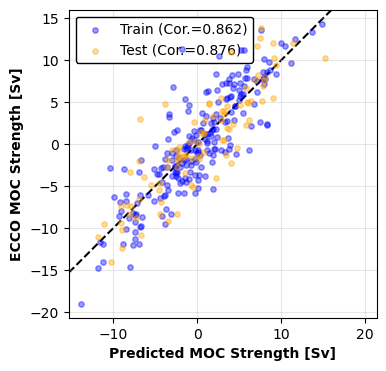

In [14]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)

plt_fp = f'/Users/emiliolr/Desktop/{filename}_scatterplot.png'
plt.savefig(plt_fp, bbox_inches = 'tight')

plt.show()